In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
import pandas as pd
from scipy import ndimage
from matplotlib.lines import Line2D

%matplotlib inline

# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
# agegrid_filename = agegrid_dir+"SampleData/1Ga_model/v2/AgeGrids_0.5d/masked/seafloor_age_mask_{:.1f}Ma.nc"

# reconstruction_times = np.arange(0,1001)

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"

reconstruction_times = np.arange(0,171)

In [44]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [45]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [36]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

In [37]:
pts_dict = dict()

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]

    pts_dict[sheet] = gplately.Points(model, df['Lon'], df['Lat'])

In [38]:
def grad(raster, tol_grad=2, iter_dilation=2, mask=True):
    image = raster.fill_NaNs()
    gradX, gradY = np.gradient(image)
    gradXY = np.hypot(gradX, gradY)
    
    mask_fz = gradXY > tol_grad

    fz_grid = np.zeros(mask_fz.shape)
    fz_grid[mask_fz] = 1
    
    if iter_dilation:
        fz_grid = ndimage.binary_dilation(fz_grid, iterations=iter_dilation)
    
    if mask:
        fz_grid[raster.data.mask] = np.nan
        
    fz_raster = gplately.Raster(array=fz_grid, extent='global')    
    
    return fz_raster

In [52]:
def plot_fz_timseries(time):
    ## Lifted from Notebook 2
    subduction_data = model.tesselate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]
    
    dlon = -1*np.sin(np.radians(trench_norm))
    dlat = -1*np.cos(np.radians(trench_norm))
    
    trench_lons += dlon
    trench_lats += dlat
    
    agegrid_raster = gplately.Raster(filename=agegrid_filename.format(time))
    fz_raster = grad(agegrid_raster, tol_grad=2, iter_dilation=2, mask=False)
    
    trench_fz = fz_raster.interpolate(trench_lons, trench_lats, method='nearest')
    
    # mask points where fracture zone intersects a subduction zone
    mask_trench_fz = trench_fz > 0
    fz_lons = trench_lons[mask_trench_fz]
    fz_lats = trench_lats[mask_trench_fz]
    
    # set up map plot
    fig = plt.figure(figsize=(16,7.5))
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 160))
    ax.set_global()
    ax.gridlines(color='0.7', linestyle=':', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))


    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.time = time # Ma
    # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
    gplot.plot_grid(ax, fz_raster.data, origin='lower', cmap='RdPu', vmin=0, vmax=1)
    gplot.plot_continents(ax, facecolor='0.8')
    gplot.plot_coastlines(ax, color='0.5')
    gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

    ax.scatter(fz_lons, fz_lats, c='yellow', transform=ccrs.PlateCarree())

    gplot.plot_trenches(ax, color='k', zorder=9)
    gplot.plot_subduction_teeth(ax, color='k', zorder=10)
    
    
    # plot metals
    legend_elements = []
    for i, sheet in enumerate(sheets):
        gpts = pts_dict[sheet]
        df = metal_dict[sheet]
        
        ages = df['Age (Ga)']*1000
        mask_ages = ages >= time
        
        # create label for each sheet and add commodities
        label = ""
        size  = np.zeros(df.shape[0])
        for commodity in commodities:
            if commodity in df:
                label += "{} + ".format(commodity[:-5])
                size  += df[commodity].fillna(0.0).to_numpy()
        label = label[:-3] + " ({})".format(sheet)
        
        if mask_ages.any():
            # reconstruct
            rlons, rlats = gpts.reconstruct(time)
            
            # print(len(size), np.count_nonzero(mask_ages), df.shape)

            sc = ax.scatter(rlons[mask_ages], rlats[mask_ages], s=10+size[mask_ages]*2, 
                            marker=symbols[i], cmap='YlGnBu',
                            vmin=0, vmax=reconstruction_times.max(),
                            label=label, transform=ccrs.PlateCarree(),
                            edgecolor='k', linewidth=0.5, zorder=11)
            
        # create legend elements
        legend_elements.append( Line2D([0],[0], color='C{}'.format(i), marker=symbols[i], label=label,
                                       linestyle='none', markeredgecolor='k', markeredgewidth=0.5) )
    
    fig.legend(handles=legend_elements, loc='center', frameon=False, bbox_to_anchor=(0.5,0), ncol=2,
               title='Mineral deposit types', title_fontsize=12)

    fig.text(0.17, 0.8, "{:4d} Ma".format(time), fontsize=12)
    
    fig.savefig("snapshots/fz_metals_{:04d}Ma.png".format(time), dpi=300, bbox_inches='tight')
    plt.close(fig)
    return None

In [53]:
plot_fz_timseries(0)

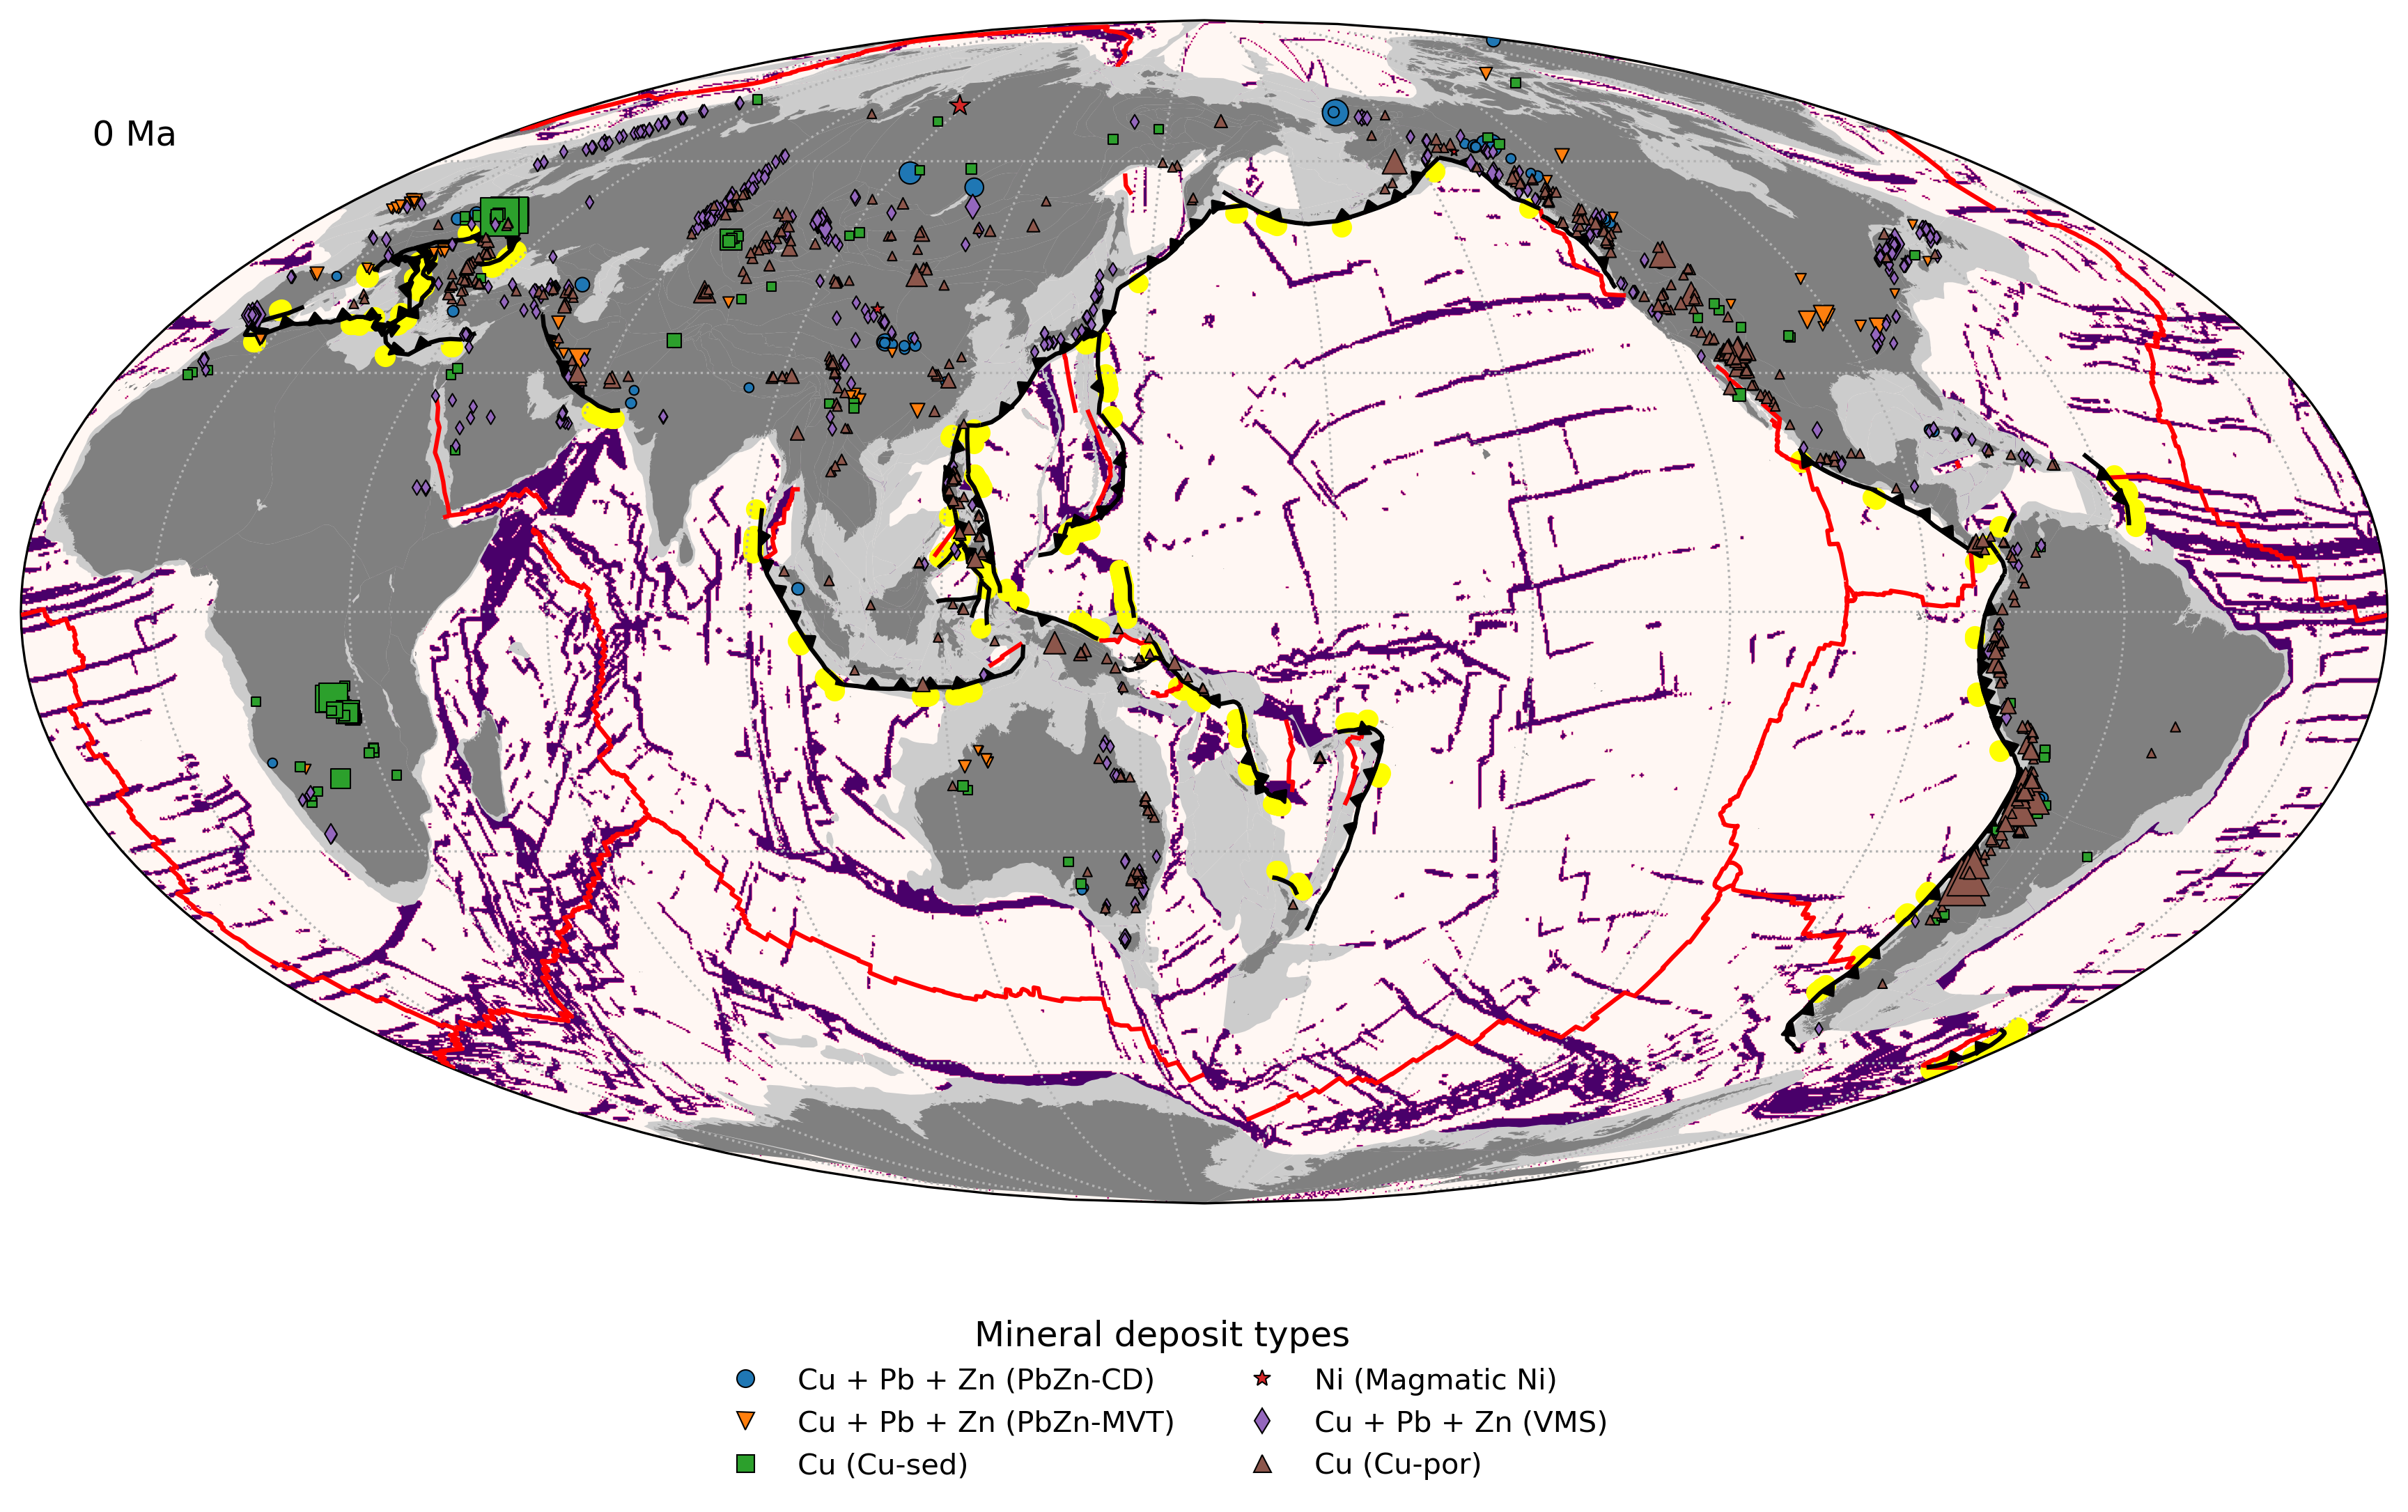

In [54]:
from IPython.display import Image
Image("snapshots/fz_metals_0000Ma.png")

completed 0
completed 1
completed 2
completed 3
completed 4
completed 5
completed 6
completed 7
completed 8
completed 9
completed 10
completed 11
completed 12
completed 13
completed 14
completed 15
completed 16
completed 17
completed 18
completed 19
completed 20
completed 21
completed 22
completed 23
completed 24
completed 25
completed 26
completed 27
completed 28
completed 29
completed 30
completed 31
completed 32
completed 33
completed 34
completed 35
completed 36
completed 37
completed 38
completed 39
completed 40
completed 41
completed 42
completed 43
completed 44
completed 45
completed 46
completed 47
completed 48
completed 49
completed 50
completed 51
completed 52
completed 53
completed 54
completed 55
completed 56
completed 57
completed 58
completed 59
completed 60
completed 61
completed 62
completed 63
completed 64
completed 65
completed 66
completed 67
completed 68
completed 69
completed 70
completed 71
completed 72
completed 73
completed 74
completed 75
completed 76
completed

UnboundLocalError: local variable 'label' referenced before assignment

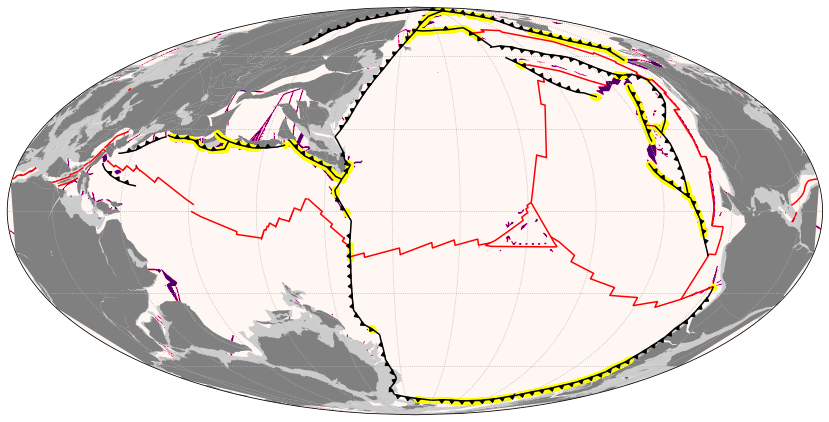

In [30]:
for time in reconstruction_times:
    plot_fz_timseries(time)
    print("completed {}".format(time))

In [9]:
from joblib import Parallel, delayed

In [ ]:
_ = Parallel(n_jobs=-3, backend='loky', verbose=1)\
    (delayed(plot_fz_timseries) (time,) for time in reconstruction_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.


Create a video using this command:

```sh
cat $(ls -r snapshots/slab_depth_*) | ffmpeg -y -f image2pipe -r 8 -i - -c:v h264_videotoolbox -b:v 6000k slab_dip_clennett_v4_no_plateaus.mp4
```